In [3]:
!pip install python-dotenv requests pandas tqdm

In [73]:
from dotenv import load_dotenv
import os

API_KEY = ""
CX = ""

assert API_KEY, "❌ Defina GOOGLE_API_KEY no seu .env"
assert CX,      "❌ Defina GOOGLE_CSE_CX no seu .env"

print("🔑 API_KEY e CX carregados com sucesso!")
# Suas credenciais para a API


🔑 API_KEY e CX carregados com sucesso!


# MINERAÇÃO COM FILTRO POR ANO

In [99]:
import os, time, requests, pandas as pd

YEARS = ["2024","2023","2022","2021","2020","2019","2018","2017","2016","2015"]
DATE_RANGES = {
    "2024": ("2024-01-01", "2024-12-31"),
    "2023": ("2023-01-01", "2023-12-31"),
    "2022": ("2022-01-01", "2022-12-31"),
    "2021": ("2021-01-01", "2021-12-31"),
    "2020": ("2020-01-01", "2020-12-31"),
    "2019": ("2019-01-01", "2019-12-31"),
    "2018": ("2018-01-01", "2018-12-31"),
    "2017": ("2017-01-01", "2017-12-31"),
    "2016": ("2016-01-01", "2016-12-31"),
    "2015": ("2015-01-01", "2015-12-31"),
}
QUERIES_TEMPLATE = [
    'site:{host} ("big data" OR "data quality") AND test* after:{start} before:{end}'
    for (start,end) in DATE_RANGES.values()
]

SOURCES = {
    "Medium":   ("medium.com",   "custom_search_links_all_Medium.csv"),
    "LinkedIn": ("linkedin.com", "custom_search_links_all_LinkedIn.csv"),
    "DevTo":    ("dev.to",       "custom_search_links_all_DevTo.csv"),
}

PAGE_SIZE = 10
MAX_START = 100

def mine_source(host: str) -> pd.DataFrame:
    records = []
    seen = set()

    # vamos tentar duas “janelas” de 100: a primeira (0–99) e a segunda (100–199)
    offsets = [0, 100]

    for year_label, q_tmpl in zip(YEARS, QUERIES_TEMPLATE):
        query = q_tmpl.format(host=host,
                           start=DATE_RANGES[year_label][0],
                           end=  DATE_RANGES[year_label][1])
        print(f"[{host}] Year={year_label}  Query: {query}")

        for offset in offsets:
            for page in range(0, 10):  # 10 páginas de 10 em 10 = 100 resultados por janela
                start = offset + page * PAGE_SIZE + 1   # start=1,11,…,91 e depois 101,111,…,191
                print(f"  → start={start}")
                resp = requests.get(
                    "https://www.googleapis.com/customsearch/v1",
                    params={"q": query, "key": API_KEY, "cx": CX, "start": start}
                )
                if resp.status_code != 200:
                    print(f"     Erro {resp.status_code}, pulando this offset")
                    break

                items = resp.json().get("items", [])
                if not items:
                    break

                for item in items:
                    link = item.get("link")
                    if link not in seen:
                        seen.add(link)
                        records.append({"Link": link, "Year": year_label})

                # se menos que uma página cheia, não há próxima página nessa janela
                if len(items) < PAGE_SIZE:
                    break

                time.sleep(1)

    return pd.DataFrame.from_records(records, columns=["Link","Year"])


def main():
    for name, (host, fname) in SOURCES.items():
        print(f"\n=== Mining {name} ===")
        df = mine_source(host)
        df.to_csv(fname, index=False)
        print(f"{name}: {len(df)} links salvos em {fname}")

if __name__ == "__main__":
    main()



=== Mining Medium ===
[medium.com] Year=2024  Query: site:medium.com ("big data" OR "data quality") AND test* after:2024-01-01 before:2024-12-31
  → start=1
  → start=11
  → start=21
  → start=31
  → start=41
  → start=51
  → start=61
  → start=71
  → start=81
  → start=91
  → start=101
     Erro 400, pulando this offset
[medium.com] Year=2023  Query: site:medium.com ("big data" OR "data quality") AND test* after:2023-01-01 before:2023-12-31
  → start=1
  → start=11
  → start=21
  → start=31
  → start=41
  → start=51
  → start=61
  → start=71
  → start=81
  → start=91
  → start=101
     Erro 400, pulando this offset
[medium.com] Year=2022  Query: site:medium.com ("big data" OR "data quality") AND test* after:2022-01-01 before:2022-12-31
  → start=1
  → start=11
  → start=21
  → start=31
  → start=41
  → start=51
  → start=61
  → start=71
  → start=81
  → start=91
  → start=101
     Erro 400, pulando this offset
[medium.com] Year=2021  Query: site:medium.com ("big data" OR "data qualit

In [89]:
import os
import time
import requests
import pandas as pd


# Mapeamento de rótulos de ano e as queries correspondentes
YEARS = ["2024", "2023", "2022", "2021", "2020", "2019", "2018", "2017", "2016", "2015"]

QUERIES_TEMPLATE = [
    'site:{host} ("big data" OR "data quality") AND test* daterange:20240101-20241231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20230101-20231231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20220101-20221231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20210101-20211231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20200101-20201231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20190101-20191231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20180101-20181231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20170101-20171231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20160101-20161231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20150101-20151231',
]

SOURCES = {
    "Medium":   ("medium.com",   "custom_search_links_all_Medium.csv"),
    "LinkedIn": ("linkedin.com", "custom_search_links_all_LinkedIn.csv"),
    "DevTo":    ("dev.to",       "custom_search_links_all_DevTo.csv"),
}

# Número máximo de resultados a buscar por page-start
PAGE_SIZE = 10
MAX_START = 100

def mine_source(host: str) -> pd.DataFrame:
    records = []
    seen = set()     # conjunto para rastrear URLs já coletadas

    for year_label, q_tmpl in zip(YEARS, QUERIES_TEMPLATE):
        query = q_tmpl.format(host=host)
        print(f"[{host}] Year={year_label}  Query: {query}")

        for start in range(1, MAX_START + 1, PAGE_SIZE):
            resp = requests.get(
                "https://www.googleapis.com/customsearch/v1",
                params={"q": query, "key": API_KEY, "cx": CX, "start": start}
            )
            if resp.status_code != 200:
                print(f"  → Erro {resp.status_code}")
                break

            items = resp.json().get("items", [])
            if not items:
                break

            for item in items:
                link = item.get("link")
                # só registra se for um link novo
                if link not in seen:
                    seen.add(link)
                    records.append({
                        "Link": link,
                        "Year": year_label
                    })

            if len(items) < PAGE_SIZE:
                break

            time.sleep(1)

    return pd.DataFrame.from_records(records, columns=["Link", "Year"])


def main():
    for source_name, (host, filename) in SOURCES.items():
        print(f"\n=== Mining {source_name} ({host}) ===")
        df = mine_source(host)
        df.to_csv(filename, index=False)
        print(f"{source_name}: salvo {len(df)} rows em '{filename}'")


if __name__ == "__main__":
    main()


=== Mining Medium (medium.com) ===
[medium.com] Year=2024  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20240101-20241231
[medium.com] Year=2023  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20230101-20231231
[medium.com] Year=2022  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20220101-20221231
[medium.com] Year=2021  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20210101-20211231
[medium.com] Year=2020  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20200101-20201231
[medium.com] Year=2019  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20190101-20191231
[medium.com] Year=2018  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20180101-20181231
[medium.com] Year=2017  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20170101-20171231
[medium.com] Year=2016  Query: site:

# MINERANDO LINKS DO STACKOVERFLOW

In [31]:
pip install requests pandas

Note: you may need to restart the kernel to use updated packages.


In [134]:
import os, time, requests, pandas as pd
from datetime import datetime
from typing import List, Dict, Tuple

SITES = ["stackoverflow", "softwareengineering.stackexchange", "sqa.stackexchange"]

# Em vez de um único booleão, fazemos duas buscas: uma por cada frase
TERMS = [
    '"big data" test*',
    '"data quality" test*'
]

YEAR_RANGES: Dict[str, Tuple[str,str]] = {
    "2024": ("2024-01-01","2024-12-31"),
    "2023": ("2023-01-01","2023-12-31"),
    "2022": ("2022-01-01","2022-12-31"),
    "2021": ("2021-01-01","2021-12-31"),
    "2020": ("2020-01-01","2020-12-31"),
    "2019": ("2019-01-01","2019-12-31"),
    "2018": ("2018-01-01","2018-12-31"),
    "2017": ("2017-01-01","2017-12-31"),
    "2016": ("2016-01-01","2016-12-31"),
    "2015": ("2015-01-01","2015-12-31"),
}

MAX_PER_YEAR = 100
PAGE_SIZE    = 30
SLEEP_SEC    = 1
OUTPUT_CSV   = "custom_search_links_all_Stackoverflow.csv"

def to_ts(d: str) -> int:
    return int(datetime.strptime(d, "%Y-%m-%d").timestamp())

def search_advanced(q: str, site: str, fd: int, td: int) -> List[str]:
    url = "https://api.stackexchange.com/2.3/search/advanced"
    collected, page = [], 1
    while len(collected) < MAX_PER_YEAR:
        params = {
            "q": q, "site": site,
            "fromdate": fd, "todate": td,
            "pagesize": PAGE_SIZE, "page": page,
            "order": "desc", "sort": "activity"
        }
        if API_KEY:
            params["key"] = API_KEY
        r = requests.get(url, params=params); r.raise_for_status()
        items = r.json().get("items", [])
        if not items:
            break
        for it in items:
            link = it["link"]
            if link not in collected:
                collected.append(link)
                if len(collected) >= MAX_PER_YEAR:
                    break
        if len(items) < PAGE_SIZE:
            break
        page += 1
        time.sleep(SLEEP_SEC)
    return collected

def main():
    out = []
    for site in SITES:
        for year, (start, end) in YEAR_RANGES.items():
            fd, td = to_ts(start), to_ts(end)
            for term in TERMS:
                print(f"Searching '{term}' on {site} for {year}")
                links = search_advanced(term, site, fd, td)
                for link in links:
                    out.append({"Link": link, "Site": site, "Year": year})
    df = pd.DataFrame(out).drop_duplicates(subset=["Link","Year"])
    df.rename(columns={"Year":"Year"}, inplace=True)  # já está Year
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Done: {len(df)} rows ⇒ {df['Link'].nunique()} unique URLs")

if __name__ == "__main__":
    main()


Searching '"big data" test*' on stackoverflow for 2024
Searching '"data quality" test*' on stackoverflow for 2024
Searching '"big data" test*' on stackoverflow for 2023
Searching '"data quality" test*' on stackoverflow for 2023
Searching '"big data" test*' on stackoverflow for 2022
Searching '"data quality" test*' on stackoverflow for 2022
Searching '"big data" test*' on stackoverflow for 2021
Searching '"data quality" test*' on stackoverflow for 2021
Searching '"big data" test*' on stackoverflow for 2020
Searching '"data quality" test*' on stackoverflow for 2020
Searching '"big data" test*' on stackoverflow for 2019
Searching '"data quality" test*' on stackoverflow for 2019
Searching '"big data" test*' on stackoverflow for 2018
Searching '"data quality" test*' on stackoverflow for 2018
Searching '"big data" test*' on stackoverflow for 2017
Searching '"data quality" test*' on stackoverflow for 2017
Searching '"big data" test*' on stackoverflow for 2016
Searching '"data quality" test*' 

# Agregando os csvs e limpando os resultados

In [136]:
import pandas as pd
import glob
import os

def combine_and_dedup(
    pattern="custom_search_links_all_*.csv",
    out_combined="aggregates_links.csv",
    out_unique="aggregates_unique_links.csv"
):
    # 1) Encontra todos os CSVs que seguem o padrão
    files = glob.glob(pattern)
    if not files:
        print(f"❌ Nenhum arquivo encontrado com o padrão {pattern}")
        return

    # 2) Carrega cada um, marca a origem e acumula
    dfs = []
    for f in files:
        source = os.path.basename(f).replace("custom_search_links_all_", "").replace(".csv", "")
        df = pd.read_csv(f)
        df["Source"] = source
        dfs.append(df)

    # 3) Concatena todos
    combined = pd.concat(dfs, ignore_index=True)
    combined.to_csv(out_combined, index=False)
    print(f"✅ Arquivos ({len(files)}) combinados em '{out_combined}' — total de linhas: {len(combined)}")

    # 4) Remove duplicatas EXATAS de URL
    unique = combined.drop_duplicates(subset=["Link"])
    unique.to_csv(out_unique, index=False)
    print(f"✅ Duplicatas removidas em '{out_unique}' — total de links únicos: {len(unique)}")

if __name__ == "__main__":
    combine_and_dedup()


✅ Arquivos (4) combinados em 'aggregates_links.csv' — total de linhas: 3301
✅ Duplicatas removidas em 'aggregates_unique_links.csv' — total de links únicos: 3301


# extraindo palavras dos posts

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

# Nome do arquivo CSV com os links de entrada
input_csv = "aggregates_unique_links.csv"  # Substitua pelo caminho do seu arquivo
output_csv = "extracted_posts_with_content.csv"  # Nome do arquivo de saída

# Carregar os links do CSV
df_links = pd.read_csv(input_csv)

# Lista para armazenar os resultados
results = []

# Função para acessar um link e extrair o título e o texto
def extract_title_and_text_from_url(url):
    print(f"Acessando: {url}")
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            # Parsear o conteúdo HTML
            soup = BeautifulSoup(response.text, 'html.parser')

            # Extrair o título da página
            title = soup.title.string.strip() if soup.title else "No Title"

            # Extrair o texto limpo de todas as tags HTML
            text = soup.get_text(separator='\n', strip=True)
            return title, text
        else:
            print(f"Falha ao acessar {url}. Status Code: {response.status_code}")
            return "No Title", "erro"
    except Exception as e:
        print(f"Erro ao acessar {url}: {e}")
        return "No Title", "erro"

# Iterar sobre os links e extrair os dados
for index, row in df_links.iterrows():
    url = row['Link']  # Substitua pelo nome da coluna que contém os links
    title, content = extract_title_and_text_from_url(url)

    # Adicionar os resultados à lista
    results.append({
        'Titulo': title,
        'Conteudo': content
    })

# Criar um DataFrame com os resultados
df_results = pd.DataFrame(results)

# Salvar os resultados em um novo arquivo CSV
df_results.to_csv(output_csv, index=False, encoding='utf-8')

print(f"Processamento concluído. Os resultados foram salvos em '{output_csv}'.")

# analise dos links duplicados individual

In [17]:
import pandas as pd
from urllib.parse import urlparse, urlunparse

# 1) Carregue o CSV (ajuste o caminho se precisar)
df = pd.read_csv("custom_search_links_all_LinkedIn.csv")

# 2) Limpeza básica
df["Link"] = df["Link"].str.strip()

# 3) Estatísticas exatas
total = len(df)
unique_exact = df["Link"].nunique()
dup_mask_exact = df["Link"].duplicated(keep=False)
dup_count_exact = dup_mask_exact.sum()

print(f"Total de linhas: {total}")
print(f"Links únicos (exatos): {unique_exact}")
print(f"Marcações de duplicados (exatas): {dup_count_exact}\n")

# 4) Mostrar alguns links não-duplicados
non_dups = df.loc[~dup_mask_exact, "Link"].drop_duplicates()
print("Exemplos de links não-duplicados (exatos):")
for link in non_dups.head(10):
    print(" •", link)

# 5) (Opcional) Normalização ignorando parâmetros de query
def normalize(url):
    p = urlparse(url)
    return urlunparse((p.scheme, p.netloc, p.path, "", "", ""))

df["Norm"] = df["Link"].apply(normalize)
unique_norm = df["Norm"].nunique()
dup_mask_norm = df["Norm"].duplicated(keep=False)
dup_count_norm = dup_mask_norm.sum()

print(f"\nDepois de normalizar (sem query params):")
print(f"Links únicos (normalizados): {unique_norm}")
print(f"Marcações de duplicados (normalizados): {dup_count_norm}")


Total de linhas: 600
Links únicos (exatos): 101
Marcações de duplicados (exatas): 599

Exemplos de links não-duplicados (exatos):
 • https://www.linkedin.com/posts/orchestra-go_snowflake-native-data-quality-and-anomaly-activity-7191094311499776000-s892

Depois de normalizar (sem query params):
Links únicos (normalizados): 101
Marcações de duplicados (normalizados): 599


In [19]:
import pandas as pd

df = pd.read_csv("custom_search_links_all_LinkedIn.csv")
df["Link"] = df["Link"].str.strip()

# Conta ocorrências de cada URL
counts = df["Link"].value_counts()

# Quantas URLs aparecem 1×, 2×, 3×, …
freq = counts.value_counts().sort_index()

print("Distribuição de quantas vezes cada link aparece:")
print(freq.to_string())

Distribuição de quantas vezes cada link aparece:
count
1     1
5     1
6    99


In [23]:
unique = df.drop_duplicates(subset=["Link"])
# unique.to_csv("devto_unique.csv", index=False)
# unique.to_csv("linkedin_unique.csv", index=False)
# unique.to_csv("medium_unique.csv", index=False)

# MINERANDO OS LINKS PARA O LDAVIS

In [27]:
pip install requests pandas beautifulsoup4 lxml

Note: you may need to restart the kernel to use updated packages.


In [151]:
"""
Este script lê links únicos de um CSV ("aggregates_unique_links.csv"),
acessa cada página, escaneia em busca de palavras-chave relacionadas
a ferramentas e métodos de teste, e grava um CSV com os resultados.
Logs métricas sobre tempo total, páginas processadas, erros, e contagens.
"""

import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import time
import logging
from datetime import timedelta

# ----- Configurações -----

INPUT_CSV       = "aggregates_unique_links.csv"
OUTPUT_CSV      = "posts_with_test_tools_and_methods.csv"
REQUEST_TIMEOUT = 10     # segundos
SLEEP_BETWEEN   = 1      # segundos entre requisições

TEST_TOOLS = [
    "JUnit", "Selenium", "TestNG", "Mockito", "Cucumber",
    "JUnit 5", "Appium", "Postman", "RestAssured",
    "Jest", "Mocha"
]
TEST_METHODS = [
    "Test-Driven Development", "Behavior-Driven Development",
    "Exploratory Testing", "Regression Testing", "Unit Testing",
    "Integration Testing", "Acceptance Testing", "Smoke Testing",
    "Load Testing"
]

# ----- Logging -----

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)

# ----- Funções -----

def scan_page_for_keywords(url: str):
    """
    Acessa a página em 'url' e retorna duas listas:
    - ferramentas encontradas (de TEST_TOOLS)
    - métodos encontrados   (de TEST_METHODS)
    """
    tools_found = []
    methods_found = []
    try:
        start = time.perf_counter()
        resp = requests.get(url, timeout=REQUEST_TIMEOUT)
        resp.raise_for_status()
        html = resp.text
        duration = time.perf_counter() - start

        text = BeautifulSoup(html, "html.parser").get_text().lower()
        for tool in TEST_TOOLS:
            if re.search(r"\b" + re.escape(tool.lower()) + r"\b", text):
                tools_found.append(tool)
        for method in TEST_METHODS:
            if re.search(r"\b" + re.escape(method.lower()) + r"\b", text):
                methods_found.append(method)

        return tools_found, methods_found, duration, None

    except Exception as e:
        return [], [], 0.0, str(e)


def main():
    df_links = pd.read_csv(INPUT_CSV)
    if "Link" not in df_links.columns:
        raise KeyError(f"Coluna 'Link' não encontrada em {INPUT_CSV}")

    unique_links = df_links["Link"].dropna().unique().tolist()
    total = len(unique_links)

    logger.info(f"Começando mineração de {total} URLs")
    t0 = time.perf_counter()

    results = []
    stats = {
        "pages": 0,
        "errors": 0,
        "total_req_time": 0.0,
        "tools_hits": 0,
        "methods_hits": 0,
    }

    for idx, url in enumerate(unique_links, start=1):
        logger.info(f"[{idx}/{total}] Scanning: {url}")
        tools, methods, req_time, error = scan_page_for_keywords(url)
        stats["pages"] += 1
        stats["total_req_time"] += req_time

        if error:
            stats["errors"] += 1
            logger.warning(f"Erro ao acessar {url}: {error}")
        else:
            stats["tools_hits"] += len(tools)
            stats["methods_hits"] += len(methods)

        results.append({
            "Link":          url,
            "Tools_Found":   "; ".join(sorted(set(tools))),
            "Methods_Found": "; ".join(sorted(set(methods)))
        })

        time.sleep(SLEEP_BETWEEN)

    df_out = pd.DataFrame(results, columns=["Link", "Tools_Found", "Methods_Found"])
    df_out.to_csv(OUTPUT_CSV, index=False)

    elapsed = time.perf_counter() - t0
    logger.info("=== Resumo da mineração ===")
    logger.info(f"Total de páginas processadas: {stats['pages']}")
    logger.info(f"Erros de requisição: {stats['errors']}")
    logger.info(f"Tempo total de requisições: {stats['total_req_time']:.2f}s")
    logger.info(f"Tempo total (incluindo pauses): {timedelta(seconds=int(elapsed))}")
    logger.info(f"Média por página (req): {stats['total_req_time']/stats['pages']:.2f}s")
    logger.info(f"Total de hits em ferramentas: {stats['tools_hits']}")
    logger.info(f"Total de hits em métodos: {stats['methods_hits']}")
    logger.info(f"Resultados salvos em '{OUTPUT_CSV}'")

if __name__ == "__main__":
    main()


03:04:51 [INFO] Começando mineração de 3301 URLs
03:04:51 [INFO] [1/3301] Scanning: https://dev.to/aws-builders/deequ-your-datas-bff-372f
03:04:52 [INFO] [2/3301] Scanning: https://dev.to/ranjbaryshahab/improving-data-quality-in-clickhouse-databases-with-soda-4kp4
03:04:54 [INFO] [3/3301] Scanning: https://dev.to/chaets/an-end-to-end-guide-to-dbt-data-build-tool-with-a-use-case-example-18mk
03:04:56 [INFO] [4/3301] Scanning: https://dev.to/oyedeletemitope/10-reasons-for-flaky-tests-5a63
03:04:57 [INFO] [5/3301] Scanning: https://dev.to/voxel51/data-quality-the-hidden-driver-of-ai-success-2i63
03:04:59 [INFO] [6/3301] Scanning: https://dev.to/doriansabitov/optimizing-salesforce-data-integration-tools-and-best-practices-2g2i
03:05:01 [INFO] [7/3301] Scanning: https://dev.to/teamcity/introducing-the-new-teamcity-plugin-for-intellij-idea-197
03:05:03 [INFO] [8/3301] Scanning: https://dev.to/aws-builders/how-i-crushed-my-aws-certification-renewals-back-to-back-and-why-it-was-a-bad-idea-56fh

# LIMPANDO CSV COM LINKS FILTRADOS

In [153]:
import pandas as pd

# Configurações de arquivo
INPUT_CSV    = "posts_with_test_tools_and_methods.csv"
OUTPUT_CLEAN = "posts_with_tools_or_methods.csv"
OUTPUT_DROP  = "posts_without_tools_or_methods.csv"

def main():
    # 1) Carrega o CSV de resultados
    df = pd.read_csv(INPUT_CSV)

    # 2) Garante que strings vazias não sejam NaN
    df["Tools_Found"]   = df["Tools_Found"].fillna("").astype(str)
    df["Methods_Found"] = df["Methods_Found"].fillna("").astype(str)

    # 3) Cria máscara para linhas sem nenhuma palavra-chave
    mask_no_kw = (
        df["Tools_Found"].str.strip().eq("") &
        df["Methods_Found"].str.strip().eq("")
    )

    # 4) Separa DataFrames
    df_with_kw    = df[~mask_no_kw].copy()
    df_without_kw = df[mask_no_kw].copy()

    # 5) Salva arquivos
    df_with_kw.to_csv(OUTPUT_CLEAN, index=False)
    df_without_kw.to_csv(OUTPUT_DROP, index=False)

    # 6) Relatório final
    print(f"✅ Links com pelo menos um termo encontrado: {len(df_with_kw)} (salvo em '{OUTPUT_CLEAN}')")
    print(f"🔶 Links sem nenhum termo encontrado  : {len(df_without_kw)} (salvo em '{OUTPUT_DROP}')")

if __name__ == "__main__":
    main()

✅ Links com pelo menos um termo encontrado: 353 (salvo em 'posts_with_tools_or_methods.csv')
🔶 Links sem nenhum termo encontrado  : 2948 (salvo em 'posts_without_tools_or_methods.csv')


# PLOTANDO GRAFICOS

C:\Users\Icaro\AppData\Local\Temp\ipykernel_49296\102288790.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, patch_artist=True, labels=labels)


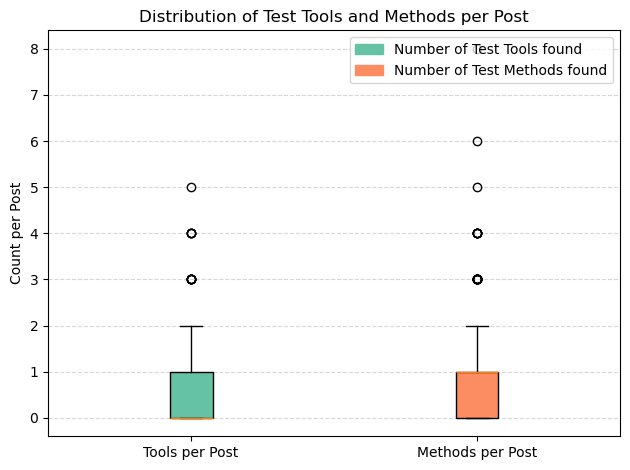

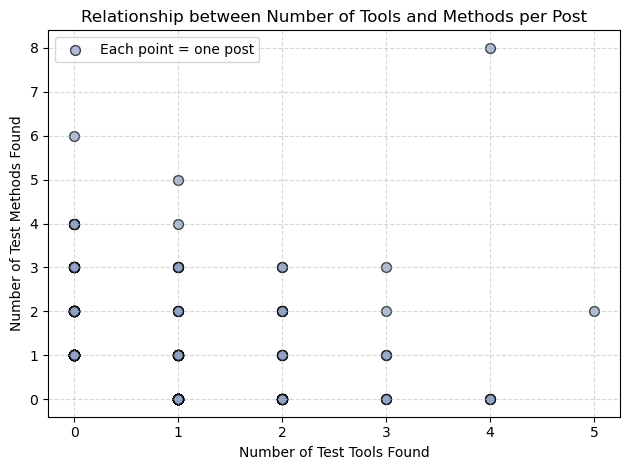

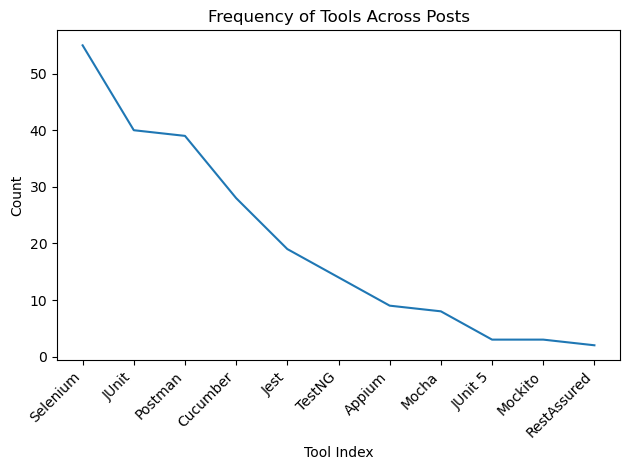

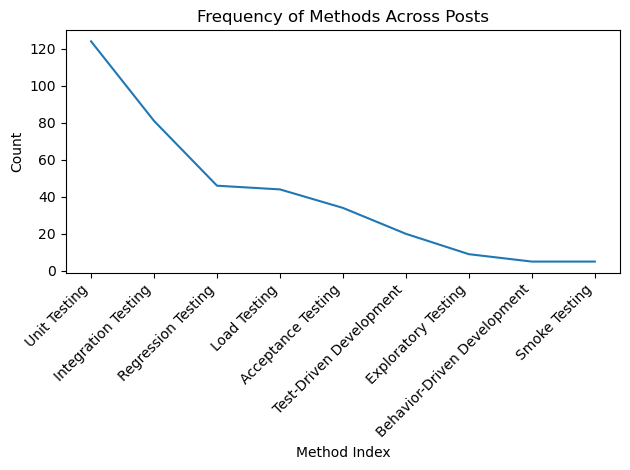

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Ajuste: Substitua o caminho pelo local correto do CSV
df = pd.read_csv("posts_with_tools_or_methods.csv")

# Limpeza e conversão de colunas para string
df["Tools_Found"] = df["Tools_Found"].fillna("").astype(str)
df["Methods_Found"] = df["Methods_Found"].fillna("").astype(str)

# Gerar colunas numéricas de contagem
df["num_tools"] = df["Tools_Found"].apply(lambda s: len([t for t in s.split("; ") if t.strip()]))
df["num_methods"] = df["Methods_Found"].apply(lambda s: len([m for m in s.split("; ") if m.strip()]))

# 1. Box‑plot com cores e legenda
fig, ax = plt.subplots()
data = [df["num_tools"], df["num_methods"]]
labels = ["Tools per Post", "Methods per Post"]
colors = ["#66c2a5", "#fc8d62"]

bp = ax.boxplot(data, patch_artist=True, labels=labels)

# aplica cores
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor("black")

# adiciona legenda manual
legend_patches = [
    mpatches.Patch(color=colors[0], label="Number of Test Tools found"),
    mpatches.Patch(color=colors[1], label="Number of Test Methods found"),
]
ax.legend(handles=legend_patches, loc="upper right")

ax.set_title("Distribution of Test Tools and Methods per Post")
ax.set_ylabel("Count per Post")
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 2. Scatter plot com legenda
fig, ax = plt.subplots()
sc = ax.scatter(
    df["num_tools"],
    df["num_methods"],
    alpha=0.7,
    s=50,
    c="#8da0cb",
    edgecolor="black",
    label="Each point = one post"
)

ax.set_title("Relationship between Number of Tools and Methods per Post")
ax.set_xlabel("Number of Test Tools Found")
ax.set_ylabel("Number of Test Methods Found")
ax.legend(loc="upper left")
ax.grid(linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Line plot: frequência de cada ferramenta
tools_exploded = df["Tools_Found"].str.split("; ").explode().dropna()
tools_exploded = tools_exploded[tools_exploded != ""]
tool_counts = tools_exploded.value_counts()

plt.figure()
plt.plot(tool_counts.values)
plt.title("Frequency of Tools Across Posts")
plt.xlabel("Tool Index")
plt.ylabel("Count")
plt.xticks(range(len(tool_counts)), tool_counts.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Line plot: frequência de cada método
methods_exploded = df["Methods_Found"].str.split("; ").explode().dropna()
methods_exploded = methods_exploded[methods_exploded != ""]
method_counts = methods_exploded.value_counts()

plt.figure()
plt.plot(method_counts.values)
plt.title("Frequency of Methods Across Posts")
plt.xlabel("Method Index")
plt.ylabel("Count")
plt.xticks(range(len(method_counts)), method_counts.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()


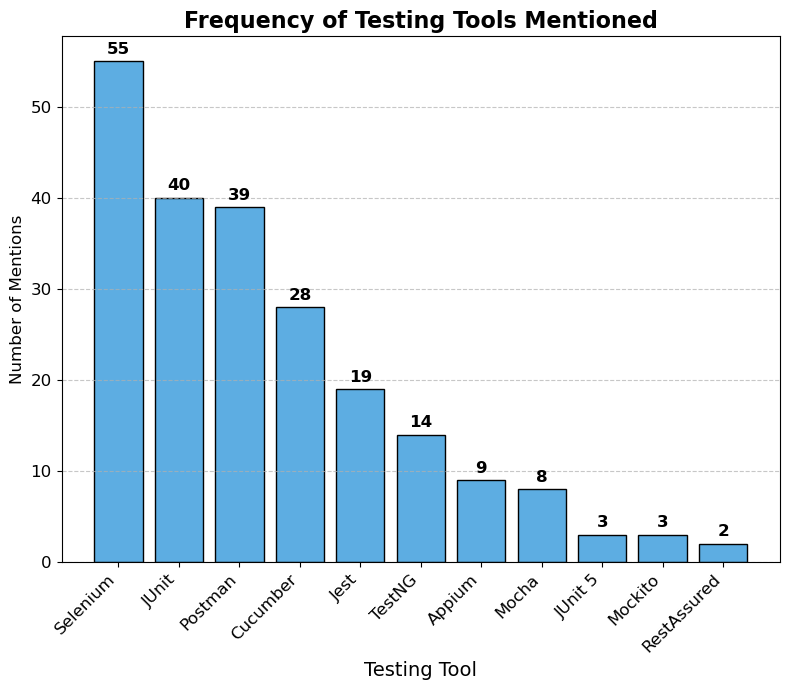

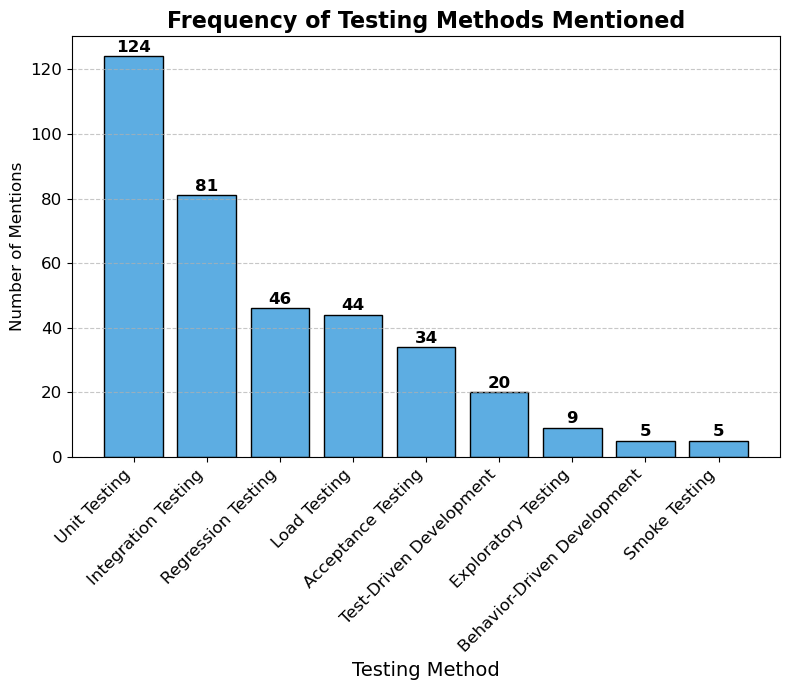

04:45:35 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04:45:35 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


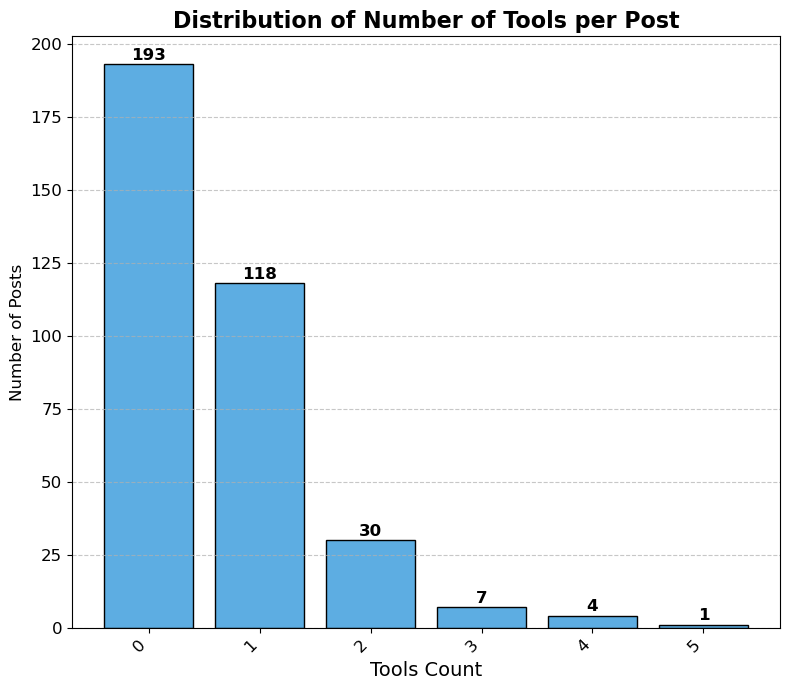

04:45:35 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04:45:35 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


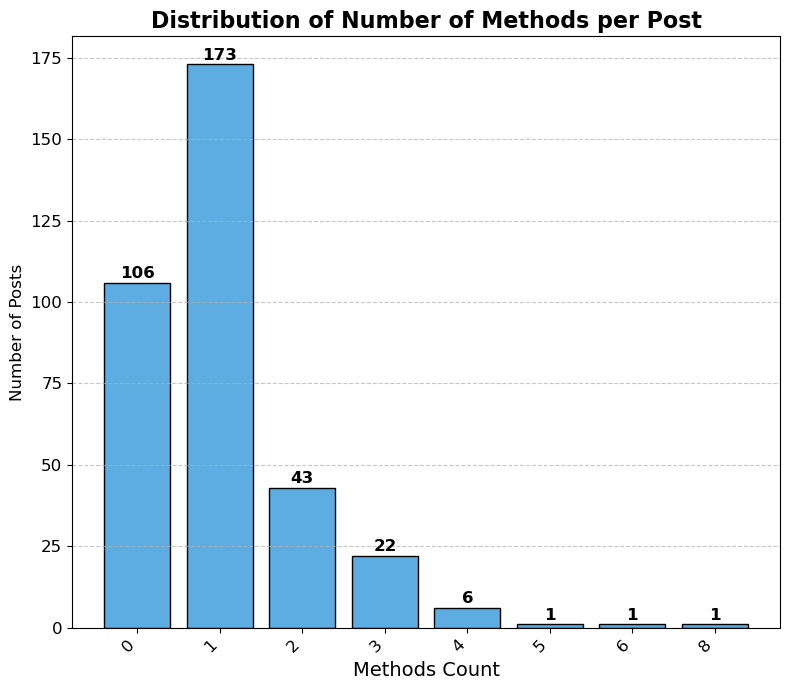

In [157]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregar dados
df = pd.read_csv("posts_with_tools_or_methods.csv")

# 2. Limpeza e conversão de colunas
df["Tools_Found"] = df["Tools_Found"].fillna("").astype(str)
df["Methods_Found"] = df["Methods_Found"].fillna("").astype(str)

# 3. Contagem de ferramentas e métodos (explodindo listas)
tools = df["Tools_Found"].str.split("; ").explode()
tools = tools[tools != ""]
tool_counts = tools.value_counts()

methods = df["Methods_Found"].str.split("; ").explode()
methods = methods[methods != ""]
method_counts = methods.value_counts()

# 4. Contagem de número de itens por post
df["num_tools"] = df["Tools_Found"].apply(lambda s: len([t for t in s.split("; ") if t]))
df["num_methods"] = df["Methods_Found"].apply(lambda s: len([m for m in s.split("; ") if m]))

tools_per_post = df["num_tools"].value_counts().sort_index()
methods_per_post = df["num_methods"].value_counts().sort_index()

# Função para plotar barras com anotações
def bar_plot(counts, title, xlabel, ylabel):
    plt.figure(figsize=(8, 7))
    bars = plt.bar(counts.index.astype(str), counts.values, color="#5DADE2", edgecolor="black")
    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                 ha="center", va="bottom", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

# 5. Plotar as quatro barras
bar_plot(tool_counts, "Frequency of Testing Tools Mentioned", "Testing Tool", "Number of Mentions")
bar_plot(method_counts, "Frequency of Testing Methods Mentioned", "Testing Method", "Number of Mentions")
bar_plot(tools_per_post, "Distribution of Number of Tools per Post", "Tools Count", "Number of Posts")
bar_plot(methods_per_post, "Distribution of Number of Methods per Post", "Methods Count", "Number of Posts")


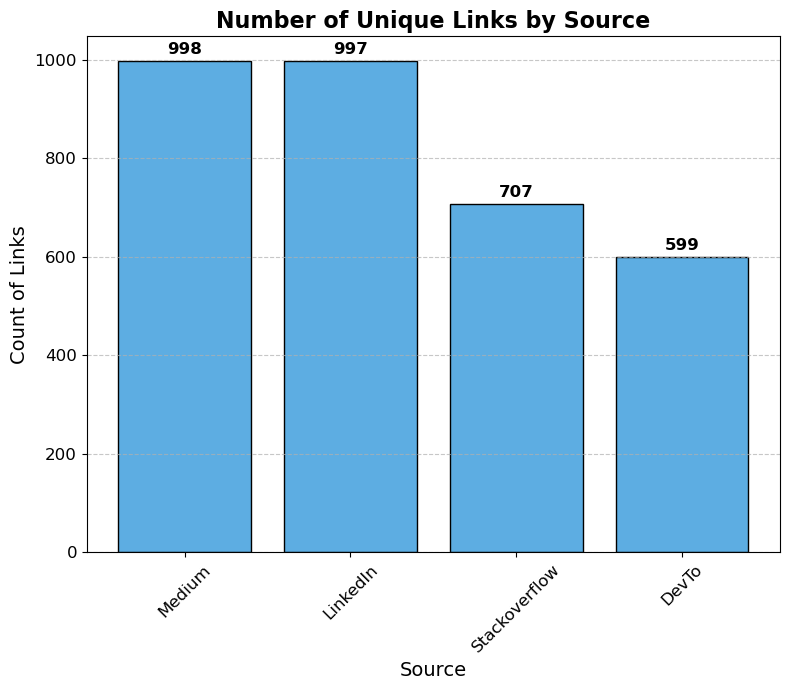

In [149]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregar o CSV com os links únicos
df = pd.read_csv("aggregates_unique_links.csv")

# 2. Contar quantos links vieram de cada Source
source_counts = df["Source"].value_counts()

# 3. Plotar gráfico de barras
fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(source_counts.index, source_counts.values,
              color="#5DADE2", edgecolor="black")

# 4. Anotar valores acima de cada barra
for bar in bars:
    h = bar.get_height()
    ax.annotate(
        f"{h}",
        xy=(bar.get_x() + bar.get_width() / 2, h),
        xytext=(0, 3),            # desloca o texto 3 pts para cima
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold"
    )

# 5. Melhorar legibilidade
ax.set_title("Number of Unique Links by Source", fontsize=16, fontweight="bold")
ax.set_xlabel("Source", fontsize=14)
ax.set_ylabel("Count of Links", fontsize=14)
ax.tick_params(axis="x", rotation=45, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


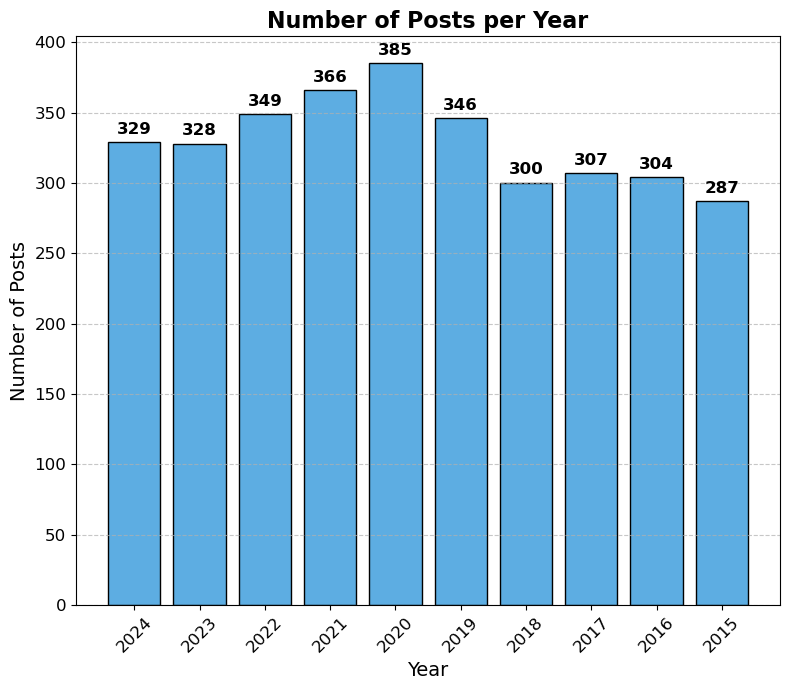

In [147]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregar os dados
df = pd.read_csv("aggregates_unique_links.csv")

# 2. Converter a coluna Year (que vinha como float 2024.0 etc.) para string "2024"
df["Year"] = df["Year"].fillna(0).astype(int).astype(str)

# Se houver alguma linha cujo Year não seja um ano válido (ex.: "0"), você pode filtrá-la:
df = df[df["Year"].str.match(r"^\d{4}$")]

# 3. Contar quantos posts por ano
year_order = ["2024", "2023", "2022", "2021", "2020",
              "2019", "2018", "2017", "2016", "2015"]
counts = df["Year"].value_counts().reindex(year_order, fill_value=0)

# 4. Plotar o gráfico de barras
fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(counts.index, counts.values,
              color="#5DADE2", edgecolor="black")

# 5. Anotar o valor exato acima de cada barra
for bar in bars:
    h = bar.get_height()
    ax.annotate(
        f"{h}",
        xy=(bar.get_x() + bar.get_width() / 2, h),
        xytext=(0, 4),
        textcoords="offset points",
        ha="center", va="bottom",
        fontsize=12, fontweight="bold"
    )

# 6. Ajustes de estilo e labels
ax.set_title("Number of Posts per Year", fontsize=16, fontweight="bold")
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Number of Posts", fontsize=14)
ax.tick_params(axis="x", rotation=45, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()
